# Normalization of the count data with visualization via PCA and heatmaps

Normalization Method: TPM and log +1

Note: The Heatmap shows only the top 10% most expressive genes

Lade LB-Daten...
Lade MCCM-Daten...
Berechne TPM...
PCA über Gene...


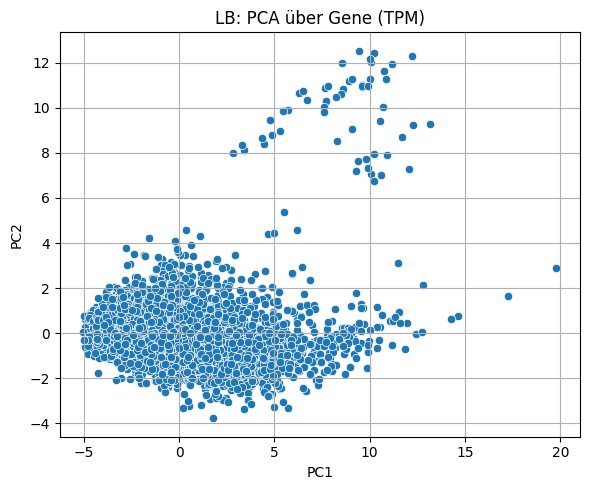

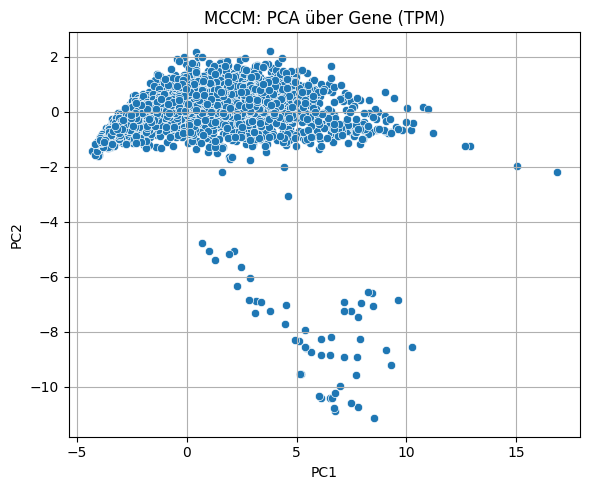

Zeige Heatmaps...


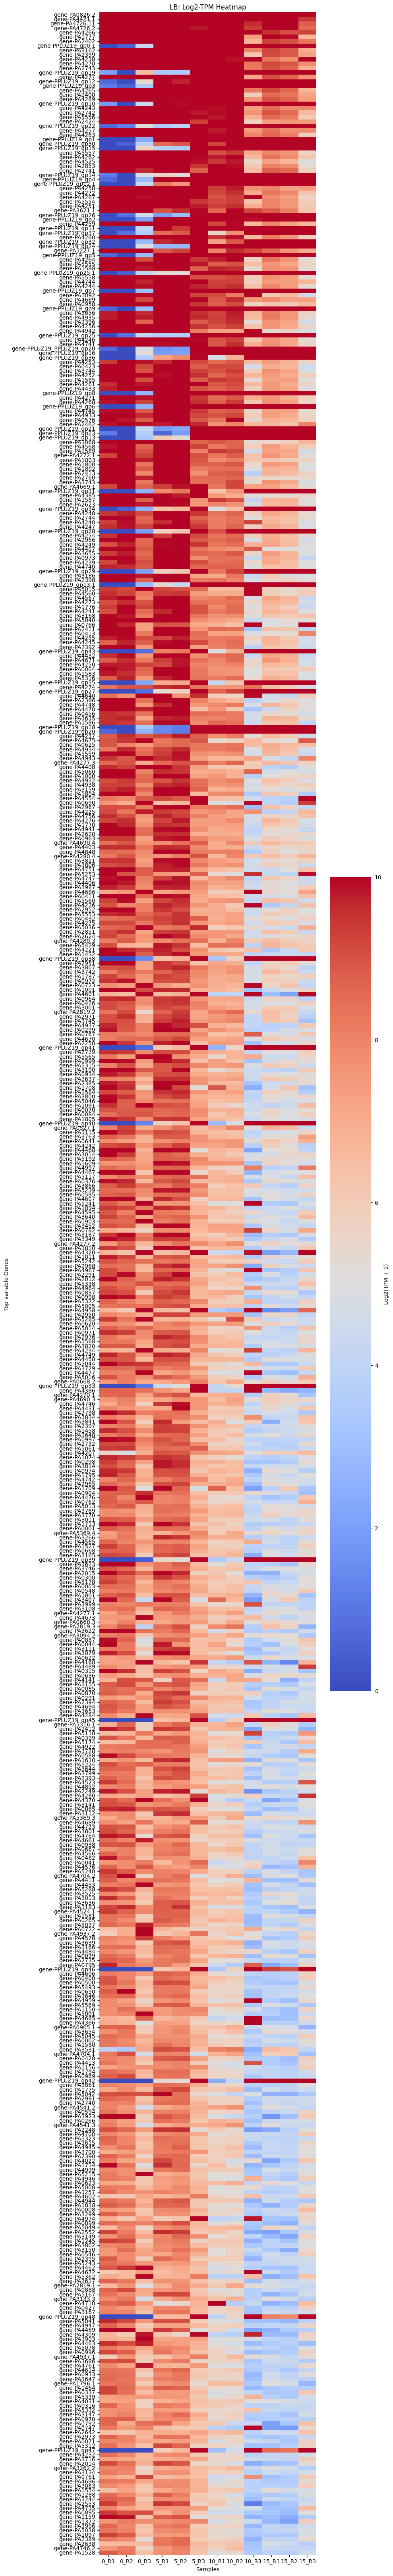

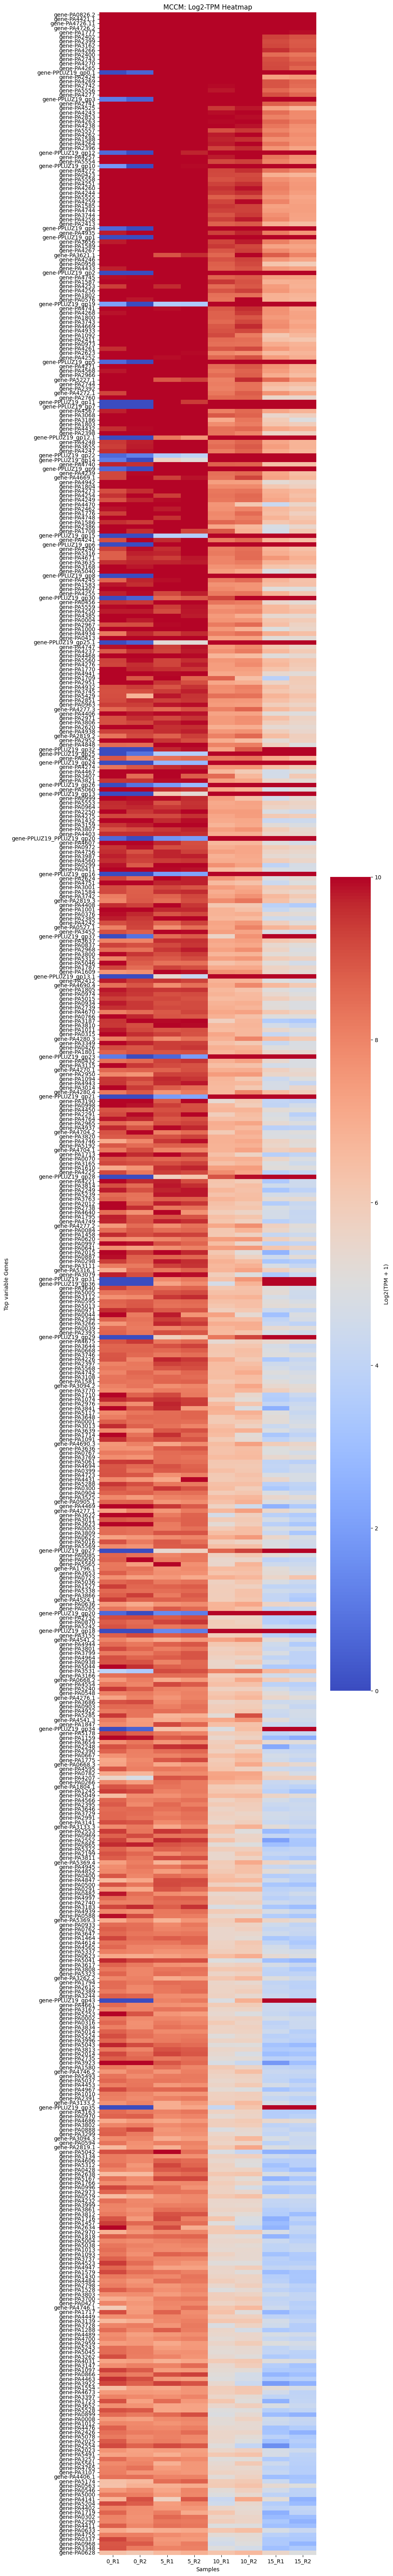

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# === Dateipfade ===
path_lb = "../data/brandao_2021/Brandao_LB_full_raw_counts.tsv"
path_mccm = "../data/brandao_2021/Brandao_MCCM_full_raw_counts.tsv"

# === Daten laden ===
def load_counts(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Datei nicht gefunden: {path}")
    df = pd.read_csv(path, sep='\t')
    df = df.set_index("Geneid")
    df = df.select_dtypes(include=[np.number])
    return df

print("Lade LB-Daten...")
lb_df = load_counts(path_lb)
print("Lade MCCM-Daten...")
mccm_df = load_counts(path_mccm)

# === Dummy-Genlängen (z. B. 1000 bp für alle Gene) ===
gene_lengths = np.ones(lb_df.shape[0]) * 1000

# === TPM-Berechnung ===
def calculate_tpm(counts, gene_lengths):
    rpk = counts / (gene_lengths[:, np.newaxis] / 1000)
    tpm = rpk / np.sum(rpk, axis=0) * 1e6
    return pd.DataFrame(tpm, index=counts.index, columns=counts.columns)

print("Berechne TPM...")
lb_tpm = calculate_tpm(lb_df, gene_lengths)
mccm_tpm = calculate_tpm(mccm_df, gene_lengths)

# === Heatmap-Funktion ===
def plot_heatmap(tpm_df, title, method="sum"):  # max_genes: zum Plotten begrenzen
    # Log2-Transformation der TPM-Werte (log2(TPM + 1))
    tpm_log = np.log2(tpm_df + 1)
    
    # Gene nach Summe der Expression oder Varianz auswählen
    if method == "sum":
        # Gene mit der höchsten Gesamtexpression auswählen
        gene_scores = tpm_log.sum(axis=1)
    elif method == "variance":
        # Gene mit der höchsten Varianz auswählen
        gene_scores = tpm_log.var(axis=1)
    else:
        raise ValueError("Methode muss 'sum' oder 'variance' sein.")

    # Top 10% Gene nach höchster Genexpression Varianz
    top_genes = gene_scores.sort_values(ascending=False).head(int(len(gene_scores) / 10)).index
    data = tpm_log.loc[top_genes]

    # Plot mit benutzerdefiniertem Color Map und Anpassung der Farbskala
    plt.figure(figsize=(10, 65))
    sns.heatmap(data, cmap="coolwarm", vmin=0, vmax=10, center=5, 
                yticklabels=True, xticklabels=True, cbar_kws={'label': 'Log2(TPM + 1)'})
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Top variable Genes")
    plt.tight_layout()
    plt.show()

# === PCA-Plot Funktion ===
def plot_pca_genes(df, title):
    # Log2-Transformation optional, falls noch nicht gemacht
    data = np.log2(df + 1)

    # Z-Standardisierung der Gene
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)  # NICHT transponieren

    # PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=components[:, 0], y=components[:, 1])
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === PCA-Plots ===
print("PCA über Gene...")
plot_pca_genes(lb_tpm, "LB: PCA über Gene (TPM)")
plot_pca_genes(mccm_tpm, "MCCM: PCA über Gene (TPM)")

# === Heatmaps ===
print("Zeige Heatmaps...")
plot_heatmap(lb_tpm, "LB: Log2-TPM Heatmap")
plot_heatmap(mccm_tpm, "MCCM: Log2-TPM Heatmap")